In [ ]:
import numpy
import pandas as pd
from matplotlib import pyplot
from datetime import datetime
%matplotlib inline

In [ ]:
#Opening all of the files
constructor_results = pd.read_csv('constructor_results.csv') #???
constructor_standings = pd.read_csv('constructor_standings.csv') #Gives the constructor standings after each race??
driver_standings = pd.read_csv('driver_standings.csv') #Gives driver standings after each race????
lap_times = pd.read_csv('lap_times.csv') #Every lap time ever
pit_stops = pd.read_csv('pit_stops.csv') #Pit stop information
qualifying = pd.read_csv('qualifying.csv') #Gives Q1, Q2, Q3 qualifying times for every driver for every race
results = pd.read_csv('results.csv') #Gives overview of race results for each driver for every race (VERY USEFUL)

## Support Files
- These files just give additional information that may be able to supplement the information in the 'useful' data files (with foreign key links)

In [ ]:
circuits = pd.read_csv('circuits.csv') #Gives information for each circuit
constructors = pd.read_csv('constructors.csv') #Relates constructorID to the constructor
drivers = pd.read_csv('drivers.csv') #Relates driverID to driver
status = pd.read_csv('status.csv') #Tells you what each statusID means
seasons = pd.read_csv('seasons.csv') #Probably uselesss, just wikipedia links
races = pd.read_csv('races.csv') #Gives race information; probably useless

# Method 1: Teammate Comparison
- Going to compare each driver directly to their teammate

## Converting Qualifying Times From a String to a Float

In [ ]:
def tosec(time):
  """Converts a time from string format to second format
  Inputs:
  time: Time in string format
  Output:
  time_s: Time in float format in seconds
  """
  if time != '\\N':
    x = datetime.strptime(time, '%M:%S.%f').time() #Turns it into a 'time' format
    minute = x.minute #Grabs the minutes
    second = x.second #Grabs the seconds
    micro = x.microsecond/1E6 #Grabs the microseconds (1E^-6 s)
    time_s = minute*60 + second + micro #Gives the lap time in seconds
    return time_s

qualifying = qualifying.dropna()

qualifying['Q1 Time'] = qualifying['q1'].apply(tosec) 
qualifying['Q2 Time'] = qualifying['q2'].apply(tosec) 
qualifying['Q3 Time'] = qualifying['q3'].apply(tosec)

## `new_qualifying` dataframe

In [ ]:
#Combingng the qualifying times and constructors information
temp_qualifying = pd.merge(qualifying, constructors, on = 'constructorId', how = 'inner')

#Adding in the driver information
new_qualifying = pd.merge(drivers, temp_qualifying, on = 'driverId', how = 'inner')
new_qualifying['driver_name'] = new_qualifying['forename'] + ' ' + new_qualifying['surname'] #Combining first and last names into one string
new_qualifying = new_qualifying.drop(['driverRef', 'code', 'dob', 'nationality_x', 'url_x', 'number_y', 'constructorRef', 'nationality_y', 'url_y', 'forename', 'surname',  'q1', 'q2', 'q3'], axis = 1) #Removing columns we won't need

#Adding in the race information (year)
new_qualifying = pd.merge(races, new_qualifying, on = 'raceId', how = 'inner')
new_qualifying['team_name'] = new_qualifying['name_y'] #Renaming this column
new_qualifying = new_qualifying.drop(['name_x', 'time', 'url', 'round', 'qualifyId', 'date', 'circuitId', 'number_x', 'name_y'], axis = 1)
new_qualifying = new_qualifying.fillna(0) #Fills any missing qualiyfing time with a 0

## Finds the Two Drivers That Competed For a Team In A Given Race

In [ ]:
def teamTimeComp(teamName, raceID):
  ''' Returns the two drivers that drove for a specific team on a given race
  Input: teamName: Name of team you are looking for. Type = str
         raceID: ID of race you want to look at. Type = int'''
  time = new_qualifying.loc[new_qualifying['team_name'] == teamName].loc[new_qualifying['raceId'] == raceID]
  return(time)

## Creating a Function To Find 'Delta Time' Between Teammates For a Given Driver



In [ ]:
def deltaTeam(driverId, raceId):
  """"
  Return the difference between a given drivers best quali time and their teammates best time at a given race
  Inputs:
  driverId = ID of the driver of interest
  raceId = ID of the race of interest

  Outputs:
  delta = Difference in time to the driver's teammate during qualifying [s]
  """
  #Gets the constructorId for the driver of interest during the given race (what team they were on in that race)
  teamId = int(new_qualifying.loc[new_qualifying['driverId'] == driverId].loc[new_qualifying['raceId'] == raceId]['constructorId'])

  #Creates a dataframe of qualifying times for the driver and their teammate for the given race
  time_table = new_qualifying.loc[new_qualifying['constructorId'] == teamId].loc[new_qualifying['raceId'] == raceId]

  #Grabbing the best time from each driver (1 is the driver of interst, 2 is the teammate)
  Q1_time_1 = float(new_qualifying.loc[new_qualifying['constructorId'] == teamId].loc[new_qualifying['raceId'] == raceId].loc[new_qualifying['driverId'] == driverId]['Q1 Time'])
  Q2_time_1 = float(new_qualifying.loc[new_qualifying['constructorId'] == teamId].loc[new_qualifying['raceId'] == raceId].loc[new_qualifying['driverId'] == driverId]['Q2 Time'])
  Q3_time_1 = float(new_qualifying.loc[new_qualifying['constructorId'] == teamId].loc[new_qualifying['raceId'] == raceId].loc[new_qualifying['driverId'] == driverId]['Q3 Time'])

  times1 = [Q1_time_1, Q2_time_1, Q3_time_1]

  #Takes the fastest qualifying time unless that qualifying time is 0
  fastest1 = 10000
  for i in times1:
    if fastest1 > i and i > 0:
      fastest1 = i

  #Finds the teammate's driverId
  ##Need `Try/Except` because when the teammate did not have a time it gives errors. When that happens it makes delta = 0.0 and that can be removed later
  try:
    teammate = int(time_table.loc[time_table['driverId'] != driverId]['driverId'])

    Q1_time_2 = float(new_qualifying.loc[new_qualifying['constructorId'] == teamId].loc[new_qualifying['raceId'] == raceId].loc[new_qualifying['driverId'] == teammate]['Q1 Time'])
    Q2_time_2 = float(new_qualifying.loc[new_qualifying['constructorId'] == teamId].loc[new_qualifying['raceId'] == raceId].loc[new_qualifying['driverId'] == teammate]['Q2 Time'])
    Q3_time_2 = float(new_qualifying.loc[new_qualifying['constructorId'] == teamId].loc[new_qualifying['raceId'] == raceId].loc[new_qualifying['driverId'] == teammate]['Q3 Time'])

    times2 = [Q1_time_2, Q2_time_2, Q3_time_2]

    fastest2 = 10000
    for i in times2:
      if fastest2 > i and i > 0:
        fastest2 = i

  except:
    fastest2 = fastest1

  #Finding the difference between the driver's fastest time and their teammates fastest time (negative is good = faster)
  delta = fastest1 - fastest2

  #Drops deltas that are +-4 seconds because those must be outliers (would not qualify for the race if they were actually that far off)
  if (delta > 4) or (delta < -4):
    delta = 0

  return delta

## Creating A Function To Find the Average 'Delta Time' For A Driver's Entire Career

In [ ]:
def delta_metric(driverId):
  """Gives the average and median delta time for a driver to their teammate
  Inputs: 
  driverId = ID of the driver of interest

  Outputs:
  delta_avg = Average delta to teammate [s]
  deltas = List of all teammates deltas over their career [s]
  """
  event = new_qualifying.loc[new_qualifying['driverId'] == driverId]['raceId'] #List of raceId's that the driver has competed in

  deltas = [] #Empty list that all of the qualifying delta times for the driver will be appended to

  for race in numpy.array(event):
    deltas.append(deltaTeam(driverId,race))

  zeros = deltas.count(0)

  delta_avg = sum(deltas)/(len(deltas) - zeros) #Takes the average but does not count the races where the delta was 0 because the 0 is artificial, not real delta
  delta_med = numpy.median(deltas)

  return delta_avg, deltas

## This Function Ranks All Of the Drivers Who Raced In A Given Season

In [ ]:
def rank(year):
  """Ranks all of the drivers for a given season
  Inputs:
  year = Year of interest

  Output:
  ranking = Dataframe ranking all of the drivers for that year
  """
  pilots = new_qualifying.loc[new_qualifying['raceId'] == races.loc[races['year'] == year]['raceId'].iloc[0]]['driverId'] #Drivers who started the first race of the season

  ranking = pd.DataFrame() #Creates and emprt dataframe to add everything to
  metric = [] #Creates and empty array for the delta times to be added to
  ranking['driverId'] = pilots #Adds the driver Id's to the dataframe

  for pilot in pilots:
    delta_avg, deltas = delta_metric(pilot)
    metric.append(delta_avg) #Using the delta_metric function to get the delta time for each driver

  ranking['Average Delta'] = metric #Adding the delta times to the dataframe

  ranking = pd.merge(ranking, drivers, on = 'driverId', how = 'inner') #Bringing in the driver data
  ranking['Driver'] = ranking['forename'] + ' ' + ranking['surname'] #Making one name column
  ranking = ranking.drop(['driverRef', 'code', 'dob', 'nationality', 'url', 'number', 'forename', 'surname', 'driverId'], axis = 1) #Removing columns
  ranking.sort_values(by = ['Average Delta'], inplace = True) #Ordering drivers
  ranking = ranking.set_index(['Driver']) #Changing the index to the driver name

  return ranking

## This Function Ranks All Drivers During a Given Time Period

In [ ]:
def range_rank(start_year, end_year, limit):
  """Ranks all of the drivers who competed over a range of seasons
  Inputs:
  start_year = First year in the range
  end_year = Last year in the range
  limit = Number of races that the drivers must have raced in to be included

  Output:
  ranking = Dataframe ranking all of the drivers for that year
  """
  years = numpy.arange(start_year, end_year+1)

  #Creating a list of unique drivers who competed during this time range
  pilots = []

  for time in years:
    people = (list(new_qualifying.loc[new_qualifying['raceId'] == races.loc[races['year'] == time]['raceId'].iloc[0]]['driverId']))
    for person in people:
      if person in pilots:
        continue
      else:
        pilots.append(person)

  ranking = pd.DataFrame() #Creates and empty dataframe to add everything to
  metric = [] #Creates and empty list for the delta times to be added to
  pilot_actual = [] #List of the drivers who have raced in enough races

  for pilot in pilots:
    delta_avg, deltas = delta_metric(pilot)
    if len(deltas) > limit: #Only incldues drivers who have raced in more than `limit` races
      metric.append(delta_avg) #Using the delta_metric function to get the delta time for each driver
      pilot_actual.append(pilot)
    else:
      continue

  ranking['Average Delta'] = metric #Adding the delta times to the dataframe
  ranking['driverId'] = pilot_actual #Adds the driver Id's to the dataframe
  ranking = pd.merge(ranking, drivers, on = 'driverId', how = 'inner') #Bringing in the driver data
  ranking['Driver'] = ranking['forename'] + ' ' + ranking['surname'] #Making one name column
  ranking = ranking.drop(['driverRef', 'code', 'dob', 'nationality', 'url', 'number', 'forename', 'surname', 'driverId'], axis = 1) #Removing columns
  ranking.sort_values(by = ['Average Delta'], inplace = True) #Ordering drivers
  ranking = ranking.set_index(['Driver']) #Changing the index to the driver name

  return ranking

In [ ]:
rankings = range_rank(2003, 2021, 40) 
rankings = rankings.reset_index()

## Plotting the Rankings

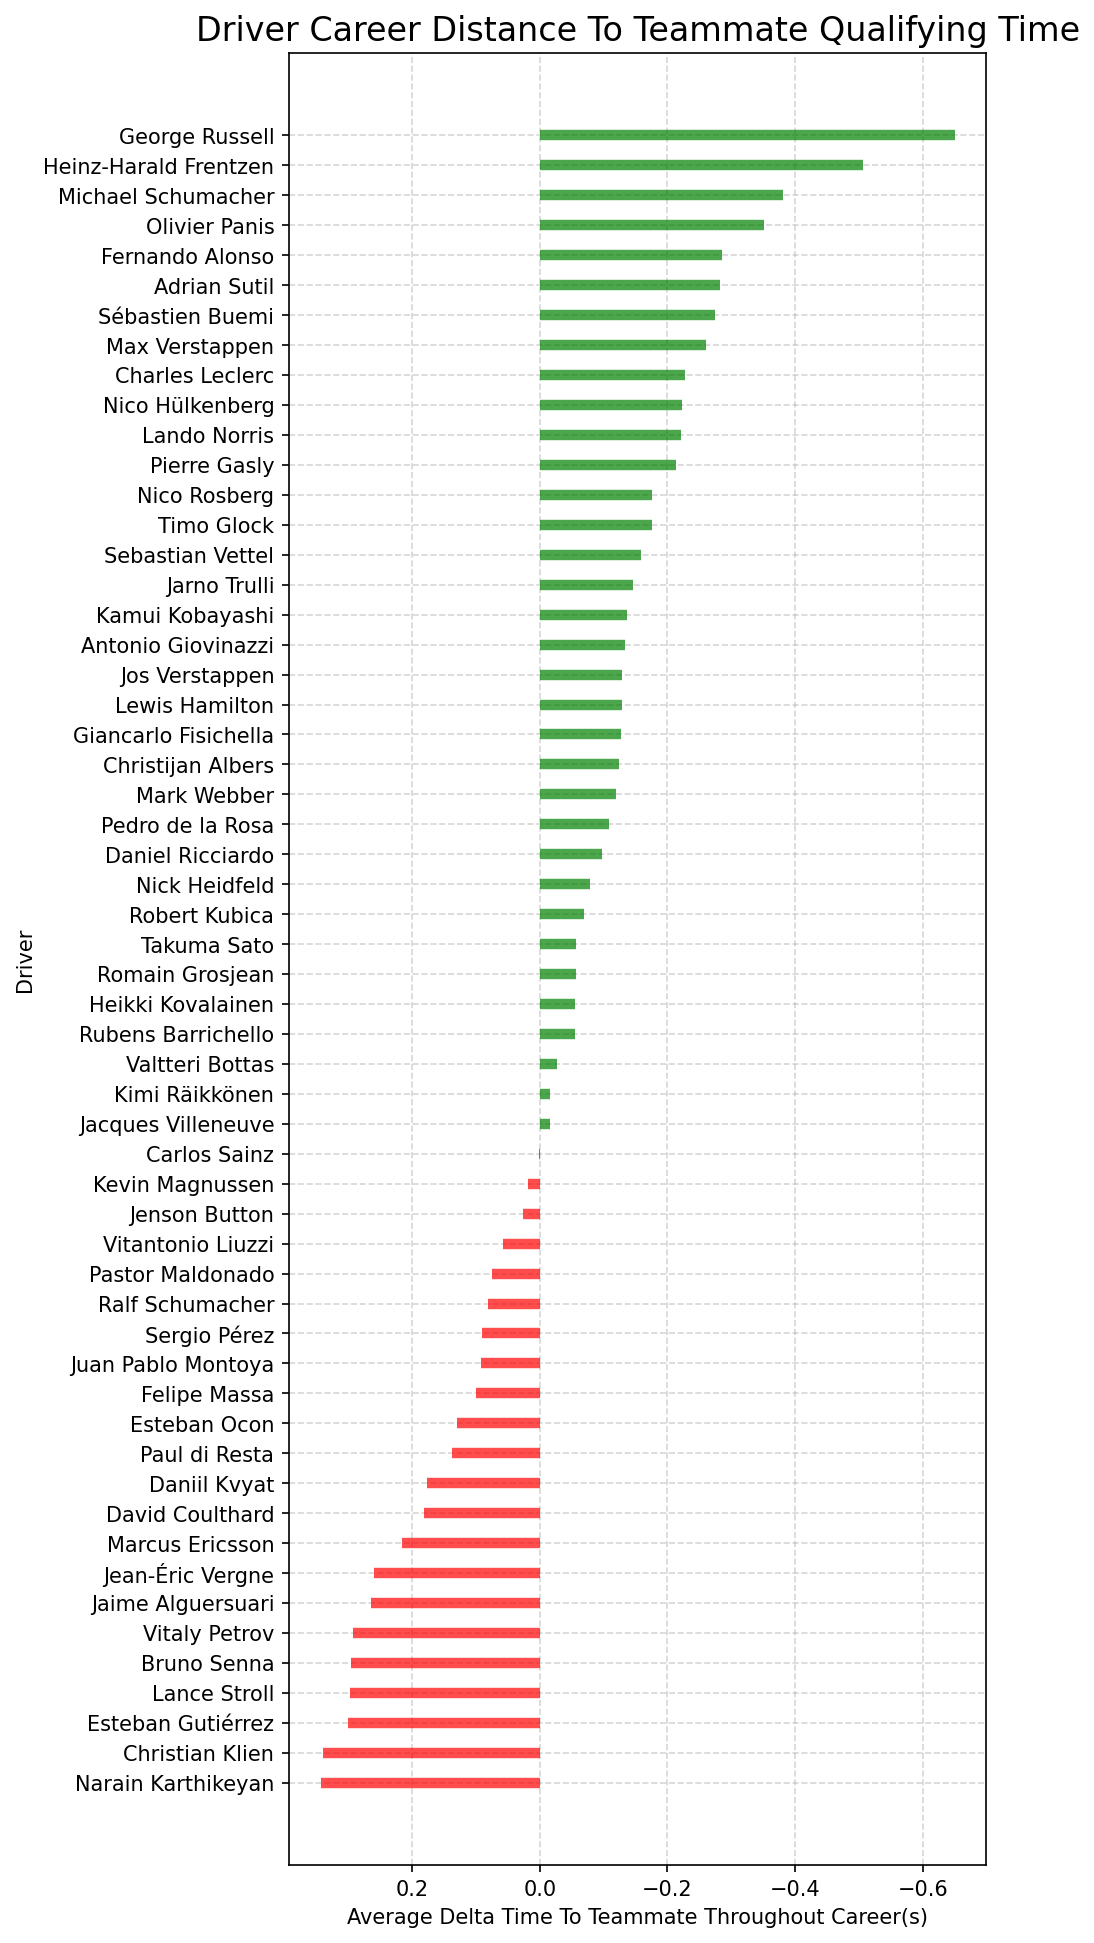

In [ ]:
rankings['colors'] = ['g' if x < 0 else 'r' for x in rankings['Average Delta']]

pyplot.figure(figsize=(6,16), dpi= 150)
pyplot.hlines(y=rankings['Driver'], xmin=0, xmax=rankings['Average Delta'], color=rankings['colors'], alpha=0.7, linewidth=5)

pyplot.gca().set(ylabel='Driver', xlabel='Average Delta Time To Teammate Throughout Career(s)')
pyplot.gca().invert_yaxis()
pyplot.gca().invert_xaxis()
pyplot.title('Driver Career Distance To Teammate Qualifying Time', fontsize= 16)
pyplot.grid(linestyle='--', alpha=0.5);

# Method 2: Grid Comparison
- This method compares a driver's qualifying times to the average qualifying time of all drivers on the grid

## This function finds the minimum qualifying time for a driver during a race

In [ ]:
def min_time(raceId, driverId):
  """Returns the fastest qualifying time for a driver at a given race
  Inputs:
  raceId = raceId of interest
  driverId = driverId of interest
  
  Ouputs:
  fastest = Fastest qualifying time from that driver
  """
  #Grabbing the qualifying time from each session
  Q1_time = float(new_qualifying.loc[new_qualifying['raceId'] == raceId].loc[new_qualifying['driverId'] == driverId]['Q1 Time'])
  Q2_time = float(new_qualifying.loc[new_qualifying['raceId'] == raceId].loc[new_qualifying['driverId'] == driverId]['Q2 Time'])
  Q3_time = float(new_qualifying.loc[new_qualifying['raceId'] == raceId].loc[new_qualifying['driverId'] == driverId]['Q3 Time'])

  times = [Q1_time, Q2_time, Q3_time] #Gathering those times

  #Takes the fastest qualifying time unless that qualifying time is 0
  fastest = 10000
  for j in times:
    if fastest > j and j > 0:
      fastest = j
        
  return fastest

## This Function Finds the Mean of a Set of Times Without Counting Times That Are 0
- This comes up a lot

In [ ]:
def mean_no_zero(series):
  """Calculates the mean of a series of data but excludes all 0s from counting towards the mean 
  Note - Throughout this code zeros are considered to be invalid times that should be ignored

  Inputs:
  series = Series that you want to no-zero mean of

  Outputs:
  mean = Mean of the series
  """
  series_list = list(series) #Have to convert to a list to use the count function
  zeros = series_list.count(0)

  if len(series_list) == zeros:
    mean = 0
  else:
    mean = sum(series_list)/(len(series_list) - zeros) #Does not consider 0 to be in the count, so it removes the 0 terms

  return mean

## This Function Find the Average Qualifying Time of All Drivers For a Race Weekend

In [ ]:
def race_avg(year):
  """Returns the average qualifying time for each race weekend of the season
  Inputs:
  year = Year of interest

  Outputs:
  season_smummary = Dataframe of average qualifying per race for a given year
  """
  events = list(new_qualifying.loc[new_qualifying['year'] == year]['raceId'].unique()) #Gets all the raceIds for the season
  pilots = list(new_qualifying.loc[new_qualifying['raceId'] == races.loc[races['year'] == year]['raceId'].iloc[0]]['driverId']) #Drivers that competed in the first race of the season

  season_avg = [] #Going to add the average qualifying time for each race of the season to this

  for event in events:
    fastest_times = [] #Going to add each driver's fastest qualifying time for a race to this dataframe
    for pilot in pilots:
      if (new_qualifying.loc[new_qualifying['raceId'] == event].loc[new_qualifying['driverId'] == pilot]['Q1 Time']).empty:
        fastest_times.append(0) #If the drivers did not compete in qualifying they do not contribute to the average
      elif min_time(event, pilot) > 250:
        continue #Does not include crazy times in the average count
      else:
        fastest_times.append(min_time(event, pilot))

    season_avg.append(mean_no_zero(fastest_times)) #Average fastest time of all drivers

  season_summary = pd.DataFrame()
  season_summary['raceId'] = events
  season_summary = pd.merge(season_summary, races, on = 'raceId', how = 'inner')
  season_summary = season_summary.drop(['round', 'circuitId', 'date', 'time', 'url', 'year'], axis = 1) #Removing columns
  season_summary['Average Qualifying Time'] = season_avg

  return season_summary

## This Function Finds a Driver's Best Qualifying Time For All Races In a Season

In [ ]:
def race_time_driver(year):
  """Returns the fastets qualifying time for each driver for each race
  Inputs:
  year = Year of interest

  Outputs:
  driver_summary = Dataframe of fastest qualifying per race per driver
  """
  #Finding the fastest qualifying time for a driver for each race of the season (there may already be a function for this)
  events = list(new_qualifying.loc[new_qualifying['year'] == year]['raceId'].unique()) #Gets all the raceIds for the season
  pilots = list(new_qualifying.loc[new_qualifying['raceId'] == races.loc[races['year'] == year]['raceId'].iloc[0]]['driverId']) #Drivers that competed in the first race of the season

  driver_summary = pd.DataFrame()
  driver_summary['raceId'] = events
  driver_summary = pd.merge(driver_summary, races, on = 'raceId', how = 'inner')
  driver_summary = driver_summary.drop(['round', 'circuitId', 'date', 'time', 'url', 'year'], axis = 1) #Removing columns

  for pilot in pilots:
    fastest_times = []
    for event in events:
      if (new_qualifying.loc[new_qualifying['raceId'] == event].loc[new_qualifying['driverId'] == pilot]['Q1 Time']).empty:
        fastest_times.append(0) #If the drivers did not compete in qualifying they do not contribute to the average
      else:
        fastest_times.append(min_time(event, pilot))  


    driver_summary[pilot] = fastest_times

  return driver_summary

## This Function Finds a Teams's Average Qualifying Time For All Races In a Season

In [ ]:
def race_time_team(year):
  """Returns the average qualifying time for each team for each race
  Inputs:
  year = Year of interest

  Outputs:
  driver_summary = Dataframe of fastest qualifying per race per driver
  """
  #Finding the fastest qualifying time for a driver for each race of the season (there may already be a function for this)
  events = list(new_qualifying.loc[new_qualifying['year'] == year]['raceId'].unique()) #Gets all the raceIds for the season
  teams = list(new_qualifying.loc[new_qualifying['raceId'] == races.loc[races['year'] == year]['raceId'].iloc[0]]['constructorId'].unique()) #Teams that competed in the first race of the season
  
  team_summary = pd.DataFrame()
  team_summary['raceId'] = events
  team_summary = pd.merge(team_summary, races, on = 'raceId', how = 'inner')
  team_summary = team_summary.drop(['round', 'circuitId', 'date', 'time', 'url', 'year'], axis = 1) #Removing columns

  for team in teams:
    fastest_times = []
    for event in events:
      race_fastest = [] #Going to add the two times for each driver to this
      pilots = list(new_qualifying.loc[new_qualifying['constructorId'] == team].loc[new_qualifying['raceId'] == event]['driverId']) #Gets the two drivers who are on that team
      for pilot in pilots:
        if (new_qualifying.loc[new_qualifying['raceId'] == event].loc[new_qualifying['driverId'] == pilot]['Q1 Time']).empty:
          race_fastest.append(0) #If the drivers did not compete in qualifying they do not contribute to the average
        else:
          race_fastest.append(min_time(event, pilot))  
      if race_fastest.count(0) == len(race_fastest):
        fastest_times.append(0)
      else:
        fastest_times.append(mean_no_zero(race_fastest))
 
    team_summary[team] = fastest_times

  return team_summary

## This Function Finds the Difference Between a Driver's Fastest Qualifying Time and the Average Qualifying Time For All Races In a Season

In [ ]:
def season_deltas_driver(year):
  """Returns a dataframe with all of the driver average delta times for a given season - Does not account for the car
  Inputs:
  year = Year of interest

  Outputs:
  delts_clean = Dataframe of average driver qualifying times and corresponding driverId
  """
  pilots = list(new_qualifying.loc[new_qualifying['raceId'] == races.loc[races['year'] == year]['raceId'].iloc[0]]['driverId']) #Drivers that competed in the first race of the season

  driver_summary = race_time_driver(year) #Gets a dataframe of fastest qualifying times for each driver over the season
  season_summary = race_avg(year) #Gets a dataframe of the average qualiyfing times at each race of the season
  avgs = numpy.array(season_summary['Average Qualifying Time'])

  delts = pd.DataFrame() #Going to add all of the delta times to the average race time to this. For each driver, it lists the delta time for each race

  pilot_teams = [] #Going to add the driver's team (constructorId) to be used later

  for pilot in pilots:
    pilot_teams.append(int(new_qualifying.loc[new_qualifying['driverId'] == pilot].loc[new_qualifying['year'] == year]['constructorId'].unique()[0]))
    x = numpy.array(driver_summary[pilot]) #Grabs a driver's qualifying times for each race of the season
    d = x - avgs #Finding the delta time between the driver's qualifying time and the average qualifying time at that race
    d_actual = [] #Will append all of the useful delta times here (-10 < t < 10)
    for d_i in d:
      if d_i < 10 and d_i > -10:
        d_actual.append(d_i) #Just getting rid of unusually high or low delta times
      else:
        d_actual.append(0) #Unusual values are given a zero and are therefore not included in the mean
    
    
    delts[pilot] = d_actual #Adding this driver's delta times to the delts dataframe

  delts2 = delts.transpose() #Rotating the dataframe so that the driverId is now the index
  delts2['Average Delta Time'] = delts2.apply(mean_no_zero, axis = 1) #Finding the no-zero mean and adding that column to the dataframe
  delts_clean = pd.DataFrame()

  #Creating a dataframe of just the average delta times and the driverId
  delts_clean['Average Delta Time'] = delts2['Average Delta Time'] #Adding the average delta times to the delts_clean dataframe
  delts_clean['driverId'] = delts2.index #Making a driverId column from the index of the delts2 dataframe
  delts_clean['constructorId'] = pilot_teams
  delts_clean.sort_values(by = ['Average Delta Time'], inplace = True) #Ordering drivers
  delts_clean = pd.merge(delts_clean, drivers, on = 'driverId', how = 'inner') #Bringing in the driver data
  delts_clean['Driver'] = delts_clean['forename'] + ' ' + delts_clean['surname'] #Making one name column
  delts_clean = delts_clean.drop(['driverRef', 'code', 'dob', 'nationality', 'url', 'number', 'forename', 'surname'], axis = 1) #Removing columns

  return delts_clean

## This Function Finds the Difference Between a Teams's Average Qualifying Time and the Average Qualifying Time For All Races In a Season

In [ ]:
def season_deltas_team(year):
  """Returns a dataframe with all of the driver average delta times for a given season - Does not account for the car
  Inputs:
  year = Year of interest

  Outputs:
  delts_clean = Dataframe of average driver qualifying times and corresponding driverId
  """
  teams = list(new_qualifying.loc[new_qualifying['raceId'] == races.loc[races['year'] == year]['raceId'].iloc[0]]['constructorId'].unique()) #Teams that competed in the first race of the season
  
  team_summary = race_time_team(year) 
  season_summary = race_avg(year)
  avgs = numpy.array(season_summary['Average Qualifying Time'])

  delts = pd.DataFrame() #Going to add all of the delta times to the average race time to this. For each driver, it lists the delta time for each race

  for team in teams:
    x = numpy.array(team_summary[team]) #Grabs a team's average qualifying time for each race of the season
    d = x - avgs #Finding the delta time between the teams's average qualifying time and the average qualifying time at that race
    d_actual = [] #Will append all of the useful delta times here (-10 < t < 10)
    for d_i in d:
      if d_i < 10 and d_i > -10:
        d_actual.append(d_i) #Just getting rid of unusually high or low delta times
      else:
        d_actual.append(0) #Unusual values are given a zero and are therefore not included in the mean
    
    
    delts[team] = d_actual #Adding this driver's delta times to the delts dataframe

  delts2 = delts.transpose() #Rotating the dataframe so that the driverId is now the index
  delts2['Average Delta Time'] = delts2.apply(mean_no_zero, axis = 1) #Finding the no-zero mean and adding that column to the dataframe
  delts_clean = pd.DataFrame()

  #Creating a dataframe of just the average delta times and the constructorId
  delts_clean['Average Delta Time'] = delts2['Average Delta Time'] #Adding the average delta times to the delts_clean dataframe
  delts_clean['constructorId'] = delts2.index #Making a driverId column from the index of the delts2 dataframe
  delts_clean.sort_values(by = ['Average Delta Time'], inplace = True) #Ordering drivers
  delts_clean = pd.merge(delts_clean, constructors, on = 'constructorId', how = 'inner') #Bringing in the driver data
  delts_clean = delts_clean.drop(['constructorRef', 'nationality', 'url'], axis = 1) #Removing columns

  return delts_clean

## This Function Normalizes Driver's 'Delta Times' Based On Team 'Delta Times' and Then Ranks Them For a Given Year

In [ ]:
def year_rank(year):
  """This function applies the appropriate change in time to each drivers delta time based on the team they drive for
  Inputs:
  year = Year of interest

  Outputs:
  delts = Dataframe of modified delta times for each driver in a season
  """
  driver_deltas = season_deltas_driver(year)
  team_deltas = season_deltas_team(year)

  pilots = list(driver_deltas['driverId'])

  driver_times_modified = [] #Going to add each driver's modified qualifying average time to this

  for pilot in pilots:
    number_of_races = len(new_qualifying.loc[new_qualifying['driverId'] == pilot])
    constructor = int(driver_deltas.loc[driver_deltas['driverId'] == pilot]['constructorId']) #Gets the constructorId of the team that the driver is on
    team_delta = float(team_deltas.loc[team_deltas['constructorId'] == constructor]['Average Delta Time']) #Grabs the average delta time for the team
    new_time = float(driver_deltas.loc[driver_deltas['driverId'] == pilot]['Average Delta Time']) - team_delta #Applies a time change based on the team
    driver_times_modified.append(new_time)

  delts = pd.DataFrame()

  delts['Average Delta Time'] = driver_times_modified
  delts['driverId'] = pilots #Making a driverId column from the index of the delts2 dataframe
  delts.sort_values(by = ['Average Delta Time'], inplace = True) #Ordering drivers
  delts = pd.merge(delts, drivers, on = 'driverId', how = 'inner') #Bringing in the driver data
  delts['Driver'] = delts['forename'] + ' ' + delts['surname'] #Making one name column
  delts = delts.drop(['driverRef', 'code', 'dob', 'nationality', 'url', 'number', 'forename', 'surname'], axis = 1) #Removing columns

  return delts

## This Function Normalizes Driver's 'Delta Times' Based On Team 'Delta Times' and Then Ranks Them For a Given Range of Years

In [ ]:
def year_range_rank(start_year, end_year, limit):
  """Ranks all of the drivers during a given time range using the second method
  Inputs:
  start_year = Start year of interest
  end_year = End year of int
  limit = Number of races that a driver must have competed in to be considered

  Outputs:
  all_ranks = Dataframe of driver rankings
  """

  years = numpy.arange(start_year, end_year)
  all_ranks = pd.DataFrame() #Going to rank all drivers in this one dataframe
  for year in years:
    all_ranks = all_ranks.append(year_rank(year)) #Appending all the dataframes together into one long dataframe


  all_ranks = all_ranks.groupby('driverId').mean()
  all_ranks = all_ranks.reset_index() #Do this to get the driverId into one of the columns
  all_ranks = pd.merge(all_ranks, drivers, on = 'driverId', how = 'inner')
  all_ranks['Driver'] = all_ranks['forename'] + ' ' + all_ranks['surname'] #Making one name column
  all_ranks = all_ranks.drop(['driverRef', 'code', 'dob', 'nationality', 'url', 'number', 'forename', 'surname'], axis = 1)
  all_ranks.sort_values(by = ['Average Delta Time'], inplace = True)

  #Removing drivers that have not raced enough races
  all_ranks = all_ranks.set_index('driverId') #Need to do this for the .drop function


  for pilot in list(all_ranks.index):
    number_of_races = len(new_qualifying.loc[new_qualifying['driverId'] == pilot]) #Find the number of races they have entered
    if number_of_races < limit:
      all_ranks.drop(pilot, inplace = True) #Removes these drivers from the list
    else:
      continue

  all_ranks.reset_index() #Now we can reset the index

  return all_ranks

In [ ]:
all_ranks = year_range_rank(2003, 2021, 40)

## Plotting The Results

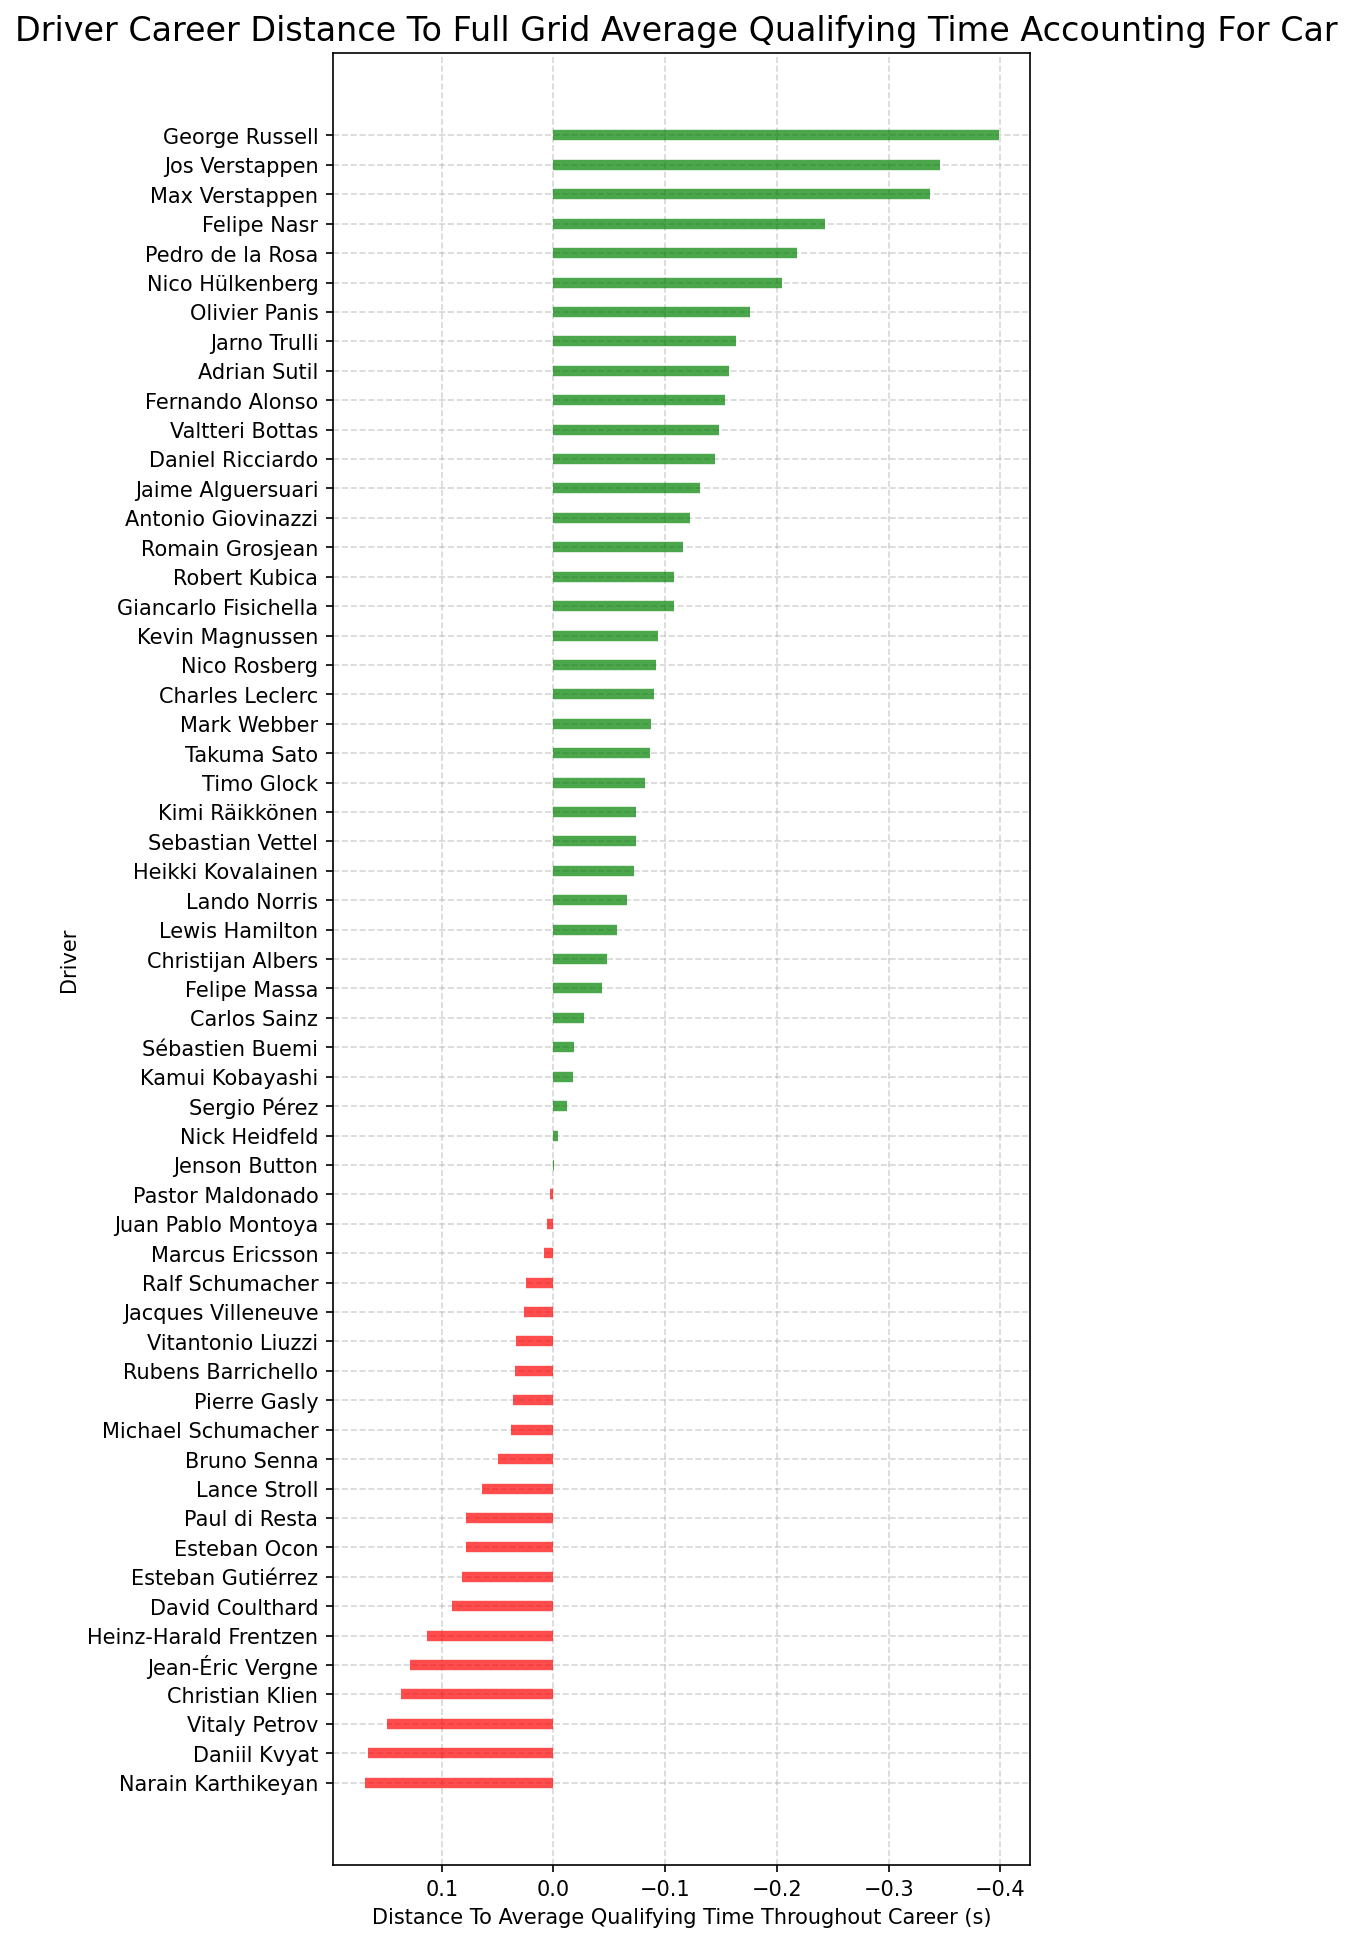

In [ ]:
all_ranks['colors'] = ['g' if x < 0.0 else 'r' for x in all_ranks['Average Delta Time']]

pyplot.figure(figsize=(6,16), dpi= 150)
pyplot.hlines(y=all_ranks['Driver'], xmin=0, xmax=all_ranks['Average Delta Time'], color=all_ranks['colors'], alpha=0.7, linewidth=5)

pyplot.gca().set(ylabel='Driver', xlabel='Distance To Average Qualifying Time Throughout Career (s)')
pyplot.gca().invert_yaxis()
pyplot.gca().invert_xaxis()
pyplot.title('Driver Career Distance To Full Grid Average Qualifying Time Accounting For Car ', fontsize= 16)
pyplot.grid(linestyle='--', alpha=0.5);

# Method 3: 

This method compares the drivers fastest lap time the the average fastest lap time of the grid.

### This function finds the average fastest lap time for each constructor for a season

In [ ]:
def conLapTime(year):
  '''Over a season, the fastest lap times for each constructor is compiled. The times are then averaged.
  Input: year - season of interest
  Output: list of constructors and their average time
  ONLY VALID FOR 2004 AND ON'''

  #splits all race ids by year
  years = numpy.arange(1950,2022,1)
  raceYear = {}
  for number in years:
    raceYear[number]= races.loc[races['year']==number]['raceId']

  #finds all race ids for given year
  df = raceYear[year]
  raceIds = []
  for value in numpy.arange(len(df.index)):
    raceIds.append(df[df.index[value]])

  if year == 2021:
    index = [2,11,12,17,18,19,20,21]
    removeId = []
    for num in index:
      removeId.append(raceIds[num])
    new = []
    for num in raceIds:
      if num not in removeId:
        new.append(num)
    raceIds = new

  #creting a list of the constructors racing in the given season
  teams = results.loc[results['raceId']==raceIds[0]]['constructorId'].unique()

  #creating data frame to be filled with mean times
  conName = []
  for num in teams:
    c = constructors.loc[constructors['constructorId']==num]['name']
    conName.append(c[c.index[0]])
  meanTimes = pd.DataFrame()
  meanTimes['constructorId'] = teams
  meanTimes['constructorName'] = conName
  meanTimes['avgTime'] = float(0)
  
  #creating data frame to be filled with all fastest lap times
  allTimes = pd.DataFrame()
  allTimes['constructorId'] = teams
  allTimes['allTime'] = str(0)

  for raceId in raceIds:
    #cleaning data for each race
    raceResults = results.loc[results['raceId']==raceId]
    x = results.loc[results['raceId']==raceId]['fastestLapTime']
    xIndex = x.index
    removeIndex = []
    for num in xIndex:
      row = x[num]
      if row == '\\N':
        removeIndex.append(num)
    for num in removeIndex:
      raceResults = raceResults.drop(num,axis=0)

    #finds both drivers times that race
    for team in teams:
      driverTimes = raceResults.loc[raceResults['constructorId']== team]['fastestLapTime']
      timeIndex = driverTimes.index
      y = allTimes.loc[allTimes['constructorId']==team]
      dfIndex = y.index
      for num in timeIndex:
        if allTimes.at[dfIndex[0],'allTime'] == '0':
          allTimes.at[dfIndex[0],'allTime'] = [driverTimes[num]]
        else:
          fill = allTimes.at[dfIndex[0],'allTime']
          fill.append(driverTimes[num])
          allTimes.at[dfIndex[0],'allTime'] = fill

  #taking all the times and finding the mean for each team
  for team in teams:
    series = allTimes.loc[allTimes['constructorId']==team]['allTime']
    teamTimes = series[series.index[0]]
    times = []
    for num in numpy.arange(len(teamTimes)):
      string = teamTimes[num]
      cut = string.split(':')
      value = (float(cut[0])*60)+float(cut[1])
      times.append(value)
    mean = numpy.mean(times)
    row = meanTimes.loc[meanTimes['constructorId']==team]
    num = row.index[0]
    meanTimes.at[num,'avgTime'] = mean
  
  times = meanTimes['avgTime']
  averageTime = numpy.mean(times)
  modTimes = times - averageTime
  meanTimes['deltaToAvg'] = modTimes
  return(meanTimes)

### This function finds the average fastest lap time for each driver over a season

In [ ]:
def driveLapTime(year):
  '''Over a season, the fastest lap times for each driver is compiled. The times are then averaged.
  Input: year - season of interest
  Output: list of drivers and their average time
  ONLY VALID FOR 2004 AND ON'''

  #splits all race ids by year
  years = numpy.arange(1950,2022,1)
  raceYear = {}
  for number in years:
    raceYear[number]= races.loc[races['year']==number]['raceId']

  #finds all race ids for given year
  df = raceYear[year]
  raceIds = []
  for value in numpy.arange(len(df.index)):
    raceIds.append(df[df.index[value]])
  
  if year == 2021:
    index = [2,11,12,17,18,19,20,21]
    removeId = []
    for num in index:
      removeId.append(raceIds[num])
    new = []
    for num in raceIds:
      if num not in removeId:
        new.append(num)
    raceIds = new

  #creting a list of the drivers racing ids in the given season
  dri = []
  con = []
  for race in raceIds:
    raceDrivers = results.loc[results['raceId']==race]['driverId']
    for num in raceDrivers:
      if num not in dri:
        dri.append(num)
        driCon = results.loc[results['raceId']==race].loc[results['driverId']==num]['constructorId']
        con.append(driCon[driCon.index[0]])

  #creating data frame to be filled with mean times
  driverName = []
  for num in dri:
    index = drivers.loc[drivers['driverId']==num]['forename'].index[0]
    fore = drivers.loc[drivers['driverId']==num]['forename'][index]
    sur = drivers.loc[drivers['driverId']==num]['surname'][index]
    name = fore + ' ' + sur
    driverName.append(name)
  meanTimes = pd.DataFrame()
  meanTimes['constructorId'] = con
  meanTimes['driverId'] = dri
  meanTimes['driverName'] = driverName
  meanTimes['avgTime'] = float(0)
  
  #creating data frame to be filled with all fastest lap times
  allTimes = pd.DataFrame()
  allTimes['driverId'] = dri
  allTimes['allTime'] = str(0)

  for raceId in raceIds:
    #cleaning data for each race
    raceResults = results.loc[results['raceId']==raceId]
    x = results.loc[results['raceId']==raceId]['fastestLapTime']
    xIndex = x.index
    removeIndex = []
    for num in xIndex:
      row = x[num]
      if row == '\\N':
        removeIndex.append(num)
    for num in removeIndex:
      raceResults = raceResults.drop(num,axis=0)

    #finds driver times for that race
    for driver in dri:
      driverTime = raceResults.loc[raceResults['driverId']== driver]['fastestLapTime']
      timeIndex = driverTime.index
      y = allTimes.loc[allTimes['driverId']==driver]
      dfIndex = y.index
      for num in timeIndex:
        if allTimes.at[dfIndex[0],'allTime'] == '0':
          allTimes.at[dfIndex[0],'allTime'] = [driverTime[num]]
        else:
          fill = allTimes.at[dfIndex[0],'allTime']
          fill.append(driverTime[num])
          allTimes.at[dfIndex[0],'allTime'] = fill

  #removing drivers who raced less than 9/16 the season
  for driver in dri:
    row = allTimes.loc[allTimes['driverId'] == driver]['allTime']
    series = row[row.index[0]]
    if len(series) < (9*len(raceIds)/16):
      allTimes = allTimes.drop(row.index[0])
      meanTimes = meanTimes.drop(row.index[0])

  #taking all the times and finding the mean for each team
  newDri = allTimes['driverId']
  for driver in newDri:
    series = allTimes.loc[allTimes['driverId']==driver]['allTime']
    driverTimes = series[series.index[0]]
    times = []
    for num in numpy.arange(len(driverTimes)):
      string = driverTimes[num]
      cut = string.split(':')
      value = (float(cut[0])*60)+float(cut[1])
      times.append(value)
    mean = numpy.mean(times)
    row = meanTimes.loc[meanTimes['driverId']==driver]
    num = row.index[0]
    meanTimes.at[num,'avgTime'] = mean
  return(meanTimes)

### This function modifies the driver time based on which car they are in

In [ ]:
def modDriver(year):
  driverLapDf = driveLapTime(year)
  conLapDf = conLapTime(year)
  driverLapDf['modAvgTime'] = float(0)

  conId = conLapDf['constructorId']
  for value in conId:
    row = conLapDf.loc[conLapDf['constructorId']==value]['deltaToAvg']
    delta = row[row.index[0]]
    driversAvgTime = driverLapDf.loc[driverLapDf['constructorId']==value]
    index = driversAvgTime.index
    for num in index:
      driverLapDf.at[num,'modAvgTime'] = driverLapDf.at[num,'avgTime'] - delta
  
  times = driverLapDf['modAvgTime']
  averageTime = numpy.mean(times)
  modTimes = times - averageTime
  driverLapDf['deltaToAvg'] = modTimes
  driverLapDf.sort_values(by = ['deltaToAvg'], inplace = True)
  return(driverLapDf)

### This function complied the modified times for multiple season and ranks the drivers based on thier time.

In [ ]:
def finalRank(startYear,endYear):
  years = numpy.arange(startYear,endYear)
  allTimes = pd.DataFrame()
  finalTimes = pd.DataFrame()

  #creating list of all drivers
  everyDriver = []
  everyName = []
  for year in years:
    df = modDriver(year)
    driver = df['driverId']
    for num in driver:
      if num not in everyDriver:
        name = df.loc[df['driverId'] == num]['driverName']
        everyName.append(name[name.index[0]])
        everyDriver.append(num)
  allTimes['driverId'] = everyDriver
  allTimes['allTimes'] = str(0)
  finalTimes['driverId'] = everyDriver
  finalTimes['driverName'] = everyName
  finalTimes['avgDelta'] = float(0)

  #adding all delta times to list for each driver then addint to allTimes df
  for year in years:
    df = modDriver(year)
    driver = df['driverId']
    for num in driver:
      row = allTimes.loc[allTimes['driverId']==num]
      rowIndex = row.index[0]
      time = df.loc[df['driverId']==num]['deltaToAvg']
      driTime = time[time.index[0]]
      if allTimes.at[rowIndex,'allTimes'] == '0':
        allTimes.at[rowIndex,'allTimes'] = [driTime]
      else:
        fill = allTimes.at[rowIndex,'allTimes']
        fill.append(driTime)
        allTimes.at[rowIndex,'allTimes'] = fill

  #finding mean delta times for all drivers
  drivers = allTimes['driverId']
  for driver in drivers:
    row = allTimes.loc[allTimes['driverId']==driver]
    rowIndex = row.index[0]
    times = allTimes.at[rowIndex,'allTimes']
    mean = numpy.mean(times)
    finalRow = finalTimes.loc[finalTimes['driverId']==driver]
    finalRowIn = finalRow.index[0]
    finalTimes.at[finalRowIn,'avgDelta'] = mean
    finalTimes.sort_values(by = ['avgDelta'], inplace = True)
  return(finalTimes)

In [ ]:
finalRankings = finalRank(2004,2021)

In [ ]:
finalRankings = finalRankings.reset_index()

### This plots the final results

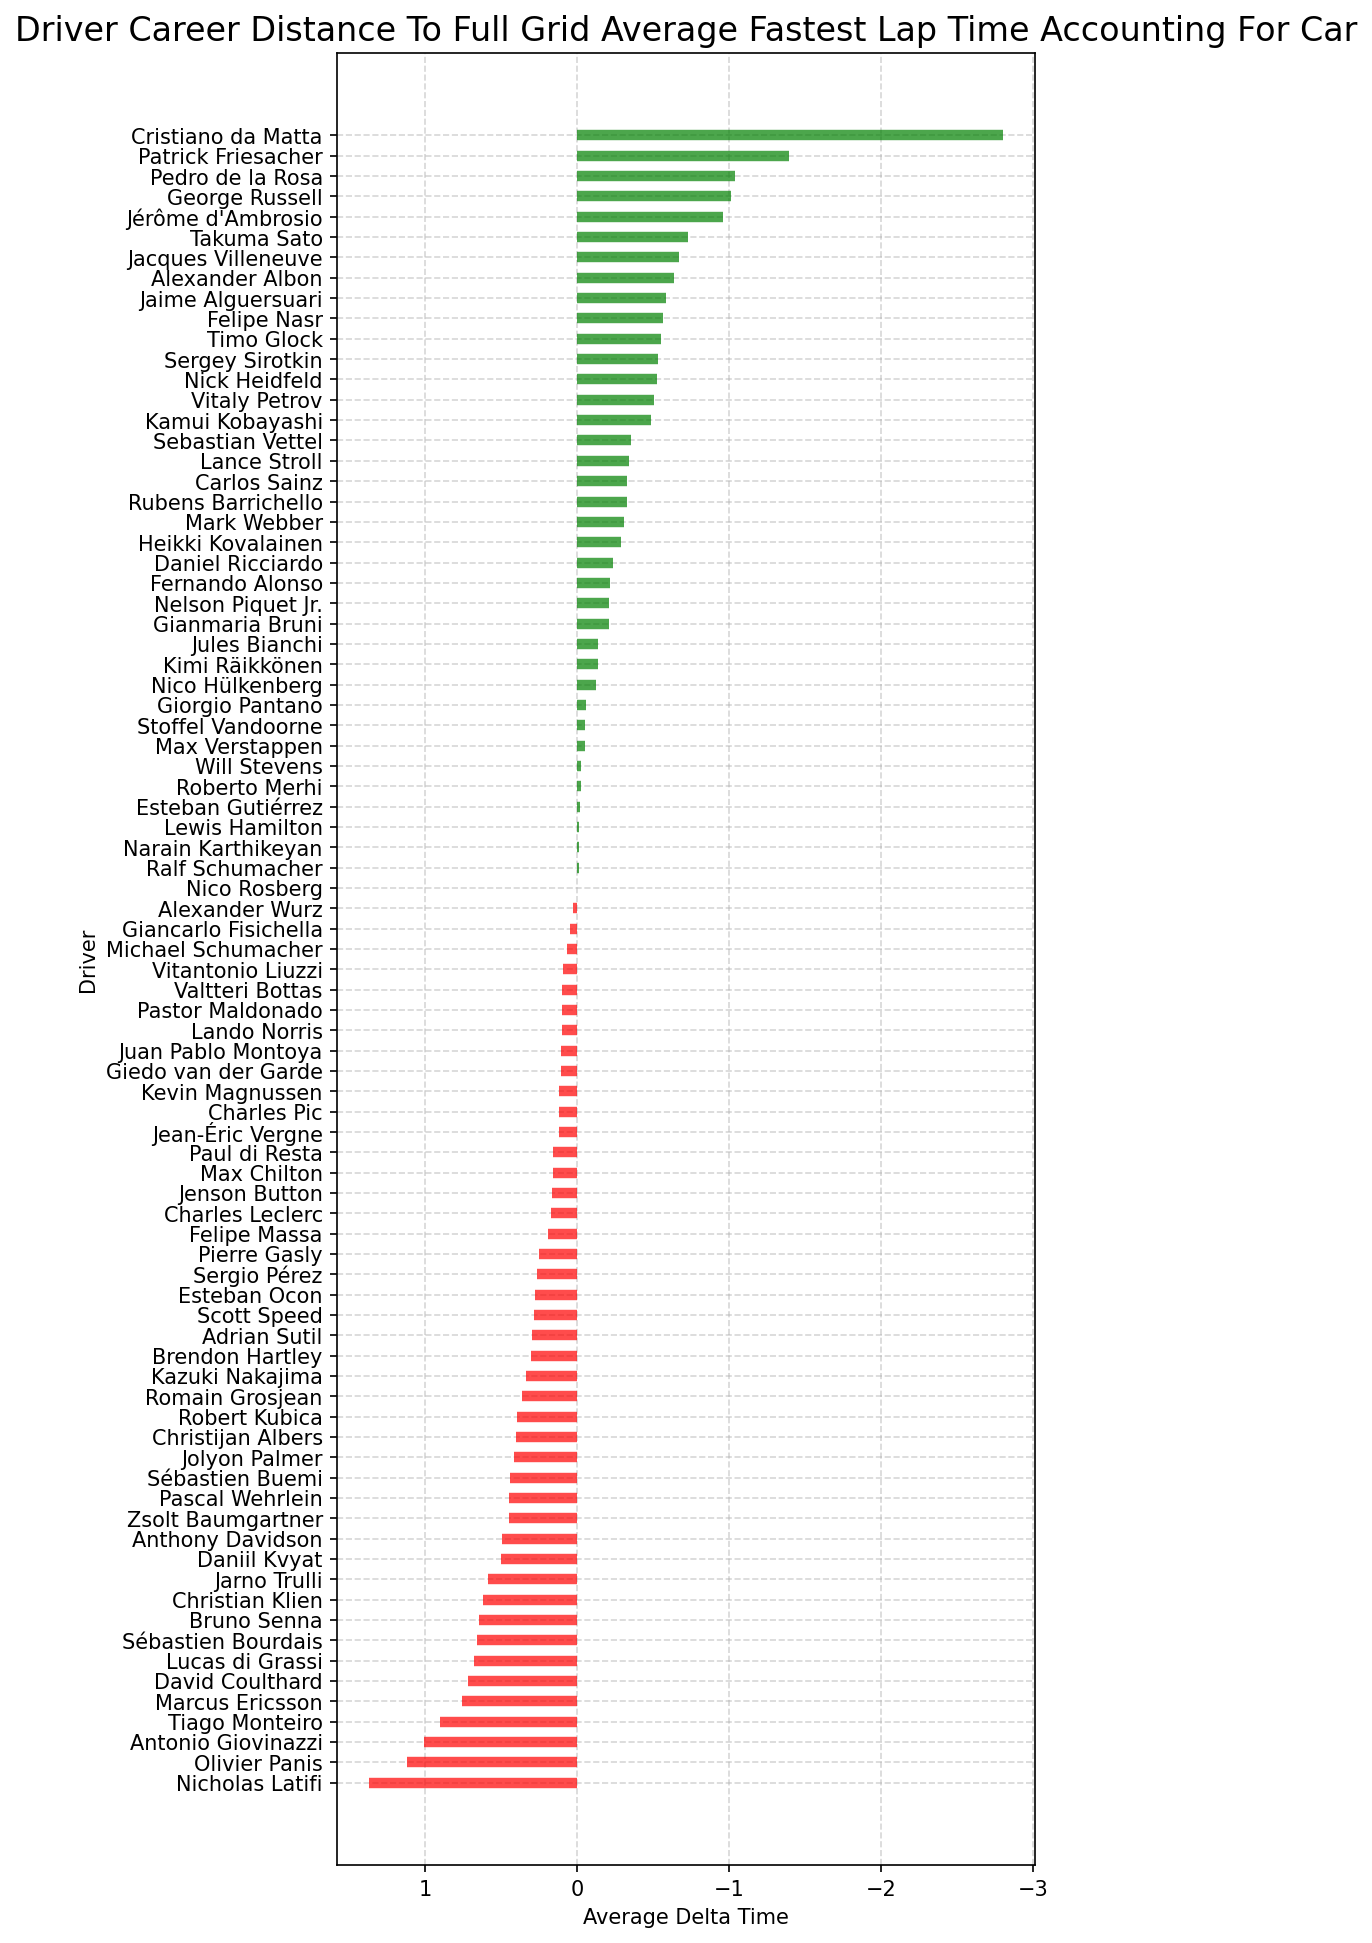

In [ ]:
finalRankings['colors'] = ['g' if x < 0 else 'r' for x in finalRankings['avgDelta']]

pyplot.figure(figsize=(6,16), dpi= 150)
pyplot.hlines(y=finalRankings['driverName'], xmin=0, xmax=finalRankings['avgDelta'], color=finalRankings['colors'], alpha=0.7, linewidth=5)

pyplot.gca().set(ylabel='Driver', xlabel='Average Delta Time')
pyplot.gca().invert_yaxis()
pyplot.gca().invert_xaxis()
pyplot.title('Driver Career Distance To Full Grid Average Fastest Lap Time Accounting For Car', fontsize= 16)
pyplot.grid(linestyle='--', alpha=0.5);